In [2]:
import random
import networkx as nx
from pyomo.environ import *
from pyomo.common.timing import TicTocTimer
import statistics
import matplotlib.pyplot as plt

In [8]:
# Componente conexa gigante de Erdos-Renyi
def loadER_GCC(seed,N,prob):
    G0 = nx.erdos_renyi_graph(N,prob,seed=seed)
    G1 = sorted(nx.connected_components(G0), key=len, reverse=True)
    # Get the giant connected component
    G2 = G0.subgraph(G1[0])
    G2 = nx.convert_node_labels_to_integers(G2)
    N = G2.number_of_nodes()
    return G2

# Erdos-Renyi
def loadER(seed,N,prob):
    G0 = nx.erdos_renyi_graph(N,prob,seed=seed)
    print("n: " + str(G0.number_of_nodes()))
    print("m: " + str(G0.number_of_edges()))
    print("cc: " + str(nx.number_connected_components(G0)))
    return G0

# Geometric random graph
def loadRGG(seed,N,r):
    G0 = nx.erdos_renyi_graph(N,r,seed=seed)
    print("n: " + str(G0.number_of_nodes()))
    print("m: " + str(G0.number_of_edges()))
    print("cc: " + str(nx.number_connected_components(G0)))
    return G0

In [9]:
def ILP(G,p,F,T,solver):
    n = G.number_of_nodes()
    
    # Valores iniciales
    b0 = { i+1: (1 if F[i] == 1 else 0) for i in range(n) }
    d0 = { i+1: 0 for i in range(n) }

    model = ConcreteModel()
    model.V = RangeSet(n)   # 1 to n
    model.R = RangeSet(T) # 1 to T

    model.b0 = Param(model.V, initialize=b0, within=Binary)
    model.d0 = Param(model.V, initialize=d0, within=Binary)

    model.b = Var(model.V, model.R, domain=Binary)
    model.d = Var(model.V, model.R, domain=Binary)

    def obj_rule(model):
        return sum(model.b[i, T] for i in model.V)

    model.OBJ = Objective(rule=obj_rule, sense=minimize)

    model.C = ConstraintList()

    for i in range(1,n+1):
        for t in model.R:
            # (2) b[i,t] >= b[i,t-1]
            if t == 1:
                model.C.add( model.b[i,t] >= model.b0[i] )
            else:
                model.C.add( model.b[i,t] >= model.b[i,t-1] )
            # (3) d[i,t] >= d[i,t-1]
            if t == 1:
                model.C.add( model.d[i,t] >= model.d0[i] )
            else:
                model.C.add( model.d[i,t] >= model.d[i,t-1] )

            # (5) b[i,t] + d[i,t] <= 1
            model.C.add( model.b[i,t] + model.d[i,t] <= 1 )

            # (4) ∀ j∈N[i]: b[i,t] + d[i,t] >= b[j,t-1]
            for j in list(G.neighbors(i-1)):
                if t == 1:
                    model.C.add( model.b[i,t] + model.d[i,t] >= model.b0[j+1] )
                else:
                    model.C.add( model.b[i,t] + model.d[i,t] >= model.b[j+1,t-1] )
            
    # (6) límite de activaciones nuevas
    def activation_limit_rule(model, t):
        expr = 0
        for i in model.V:
            if t == 1:
                expr += (model.d[i,1] - model.d0[i])
            else:
                expr += (model.d[i,t] - model.d[i,t-1])
        return expr <= p
    model.ActLimit = Constraint(model.R, rule=activation_limit_rule)

    timer = TicTocTimer()
    timer.tic('starting timer') # starts the elapsed time timer (from 0)
    
    # Ejemplo con CBC (lineal-entero)
    SolverFactory(solver).solve(model, tee=False)
    
    runtime = timer.toc('runtime')

    b_sol = {(i,t): model.b[i,t].value for i in range(1,n+1) for t in model.R}
    d_sol = {(i,t): model.d[i,t].value for i in range(1,n+1) for t in model.R}
    print("Objetivo:", model.OBJ(), "\n")

    '''
    print("Quemados (b):")
    for j in range(1, T + 1):
        print(" ", j, end = " ")
    print()
    for i in range(1,n+1):
        print(i, end= " ")
        for j in range(1, T + 1):
            print(b_sol[(i, j)], end=" ")
        print()

    print("Defendidos (d):")
    for j in range(1, T + 1):
        print(" ", j, end = " ")
    print()
    for i in range(1,n+1):
        print(i, end= " ")
        for j in range(1, T + 1):
            print(d_sol[(i, j)], end=" ")
    '''
    return runtime

In [66]:
def IQCP(G,p,F,T,solver):
    n = G.number_of_nodes()
    model = ConcreteModel()
    model.V = RangeSet(n)   # 1 to n
    model.R = RangeSet(T+1) # 1 to T+1

    model.x = Var(model.V, model.R, domain=Binary)

    def obj_rule(model):
        return sum(model.x[i, T]-model.x[i, T+1] for i in model.V)

    model.OBJ = Objective(rule=obj_rule, sense=minimize)

    model.C = ConstraintList()

    # (16)
    for i in range(1,n+1):
        if F[i-1] == 1:
            model.C.add( model.x[i,T+1] == 0 )
    
    for i in range(1,n+1):
        for t in range(1,T+1):
            # (13)
            N = list(G.neighbors(i-1))
            N.append(i-1)
            #print(N)
            for j in N:
                if t == 1:
                    model.C.add( model.x[i,t] >= F[j] - model.x[j+1,T+1] )
                else:
                    model.C.add( model.x[i,t] >= model.x[j+1,t-1] - model.x[j+1,T+1] )
        # (15)
        model.C.add( model.x[i,T] >= model.x[i,T+1] )
            
    # (14)
    for t in range(1,T+1):
        expr = 0
        for i in model.V:
            expr += (model.x[i,t] * model.x[i,T+1])
        model.C.add( expr <= t*p)

    timer = TicTocTimer()
    timer.tic('starting timer') # starts the elapsed time timer (from 0)
    
    # Ejemplo con CBC (lineal-entero)
    SolverFactory(solver).solve(model, tee=False)
    
    runtime = timer.toc('runtime')

    #b_sol = {(i,t): model.b[i,t].value for i in range(1,n+1) for t in model.R}
    #d_sol = {(i,t): model.d[i,t].value for i in range(1,n+1) for t in model.R}
    print("Objetivo:", model.OBJ(), "\n")

    '''
    print("Quemados (b):")
    for j in range(1, T + 1):
        print(" ", j, end = " ")
    print()
    for i in range(1,n+1):
        print(i, end= " ")
        for j in range(1, T + 1):
            print(b_sol[(i, j)], end=" ")
        print()

    print("Defendidos (d):")
    for j in range(1, T + 1):
        print(" ", j, end = " ")
    print()
    for i in range(1,n+1):
        print(i, end= " ")
        for j in range(1, T + 1):
            print(d_sol[(i, j)], end=" ")
    '''
    return runtime

In [71]:
solver = 'scip'# gurobi o scip
program = 'IQCP' # IQCP o ILP

f = open('output.txt', 'a+')
f.write(solver + '\n')
f.write(program + '\n')
#for q in [100,200,300,400,500]:
for q in [100]:
    N = q
    f.write('-------------------------- \n')
    f.write('n de G(n,p): ' + str(N) + '\n')
    print('n de G(n,p): ' + str(N) + '\n')
    order_all = []
    size_all = []
    runtime_all = []
    stdev_all = []
    for r in [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3]:
        prob = r/(N)
        runtimes = []
        order = []
        size = []
        print('p de G(n,p): ' + str(r) + '/N' + '\n')
        for seed in range(30):
            random.seed(seed)
            G = loadER_GCC(seed,N,prob)
            #G = gb.load_graph('grid5x5')
            order.append(G.number_of_nodes())
            size.append(G.number_of_edges())
            n = G.number_of_nodes()
            p = 1
            F = [0]*n
            for i in random.sample(range(0, n), 2): # number of fire sources
                F[i] = 1
            T = 0
            for i in range(n):
                min_dist = float("inf")
                for j in F:
                    dist = nx.shortest_path_length(G,source=i,target=j)
                    if dist < min_dist:
                        min_dist = dist
                if min_dist > T:
                    T = min_dist
            if program == 'ILP':
                runtime = ILP(G,p,F,T,solver)
            if program == 'IQCP':
                runtime = IQCP(G,p,F,T,solver)
            runtimes.append(runtime)
        order_all.append(sum(order)/len(order))
        size_all.append(sum(size)/len(size))
        runtime_all.append(sum(runtimes)/len(runtimes))
        stdev_all.append(statistics.stdev(runtimes))
    
    f.write("Mean order: " + str(order_all) + '\n')
    f.write("Mean size: " + str(size_all) + '\n')
    f.write("Mean runtime: " + str(runtime_all) + '\n')
    f.write("Mean stdev runtime: " + str(stdev_all) + '\n')
        #f.write("Order: " + str(sum(order)/len(order)) + '\n')
        #f.write("Size: " + str(sum(size)/len(size)) + '\n')
        #f.write("Mean runtime: " + str(sum(runtimes)/len(runtimes)) + '\n')
        #f.write("Stdev runtime: " + str(statistics.stdev(runtimes)) + '\n')
    f.write('\n')
        #print("Order: " + str(sum(order)/len(order)))
        #print("Size: " + str(sum(size)/len(size)))
        #print("Mean runtime: " + str(sum(runtimes)/len(runtimes)))
        #print("Stdev runtime: " + str(statistics.stdev(runtimes)))
f.close()

n de G(n,p): 100

p de G(n,p): 1/N

[    0.00] starting timer
[+   0.20] runtime
Objetivo: 9.0 

[    0.00] starting timer
[+   0.13] runtime
Objetivo: 4.0 

[    0.00] starting timer
[+   0.14] runtime
Objetivo: 4.0 

[    0.00] starting timer
[+   0.06] runtime
Objetivo: 3.0 

[    0.00] starting timer
[+   0.18] runtime
Objetivo: 9.0 

[    0.00] starting timer
[+   0.05] runtime
Objetivo: 5.0 

[    0.00] starting timer
[+   0.07] runtime
Objetivo: 7.0 

[    0.00] starting timer
[+   0.05] runtime
Objetivo: 4.0 

[    0.00] starting timer
[+   0.04] runtime
Objetivo: 4.0 

[    0.00] starting timer
[+   0.11] runtime
Objetivo: 7.0 

[    0.00] starting timer
[+   0.05] runtime
Objetivo: 5.0 

[    0.00] starting timer
[+   0.04] runtime
Objetivo: 4.0 

[    0.00] starting timer
[+   0.05] runtime
Objetivo: 3.0 

[    0.00] starting timer
[+   0.16] runtime
Objetivo: 6.0 

[    0.00] starting timer
[+   0.06] runtime
Objetivo: 7.0 

[    0.00] starting timer
[+   0.07] runtime
Obje

[+   8.04] runtime
Objetivo: 18.0 

[    0.00] starting timer
[+   0.56] runtime
Objetivo: 10.0 

[    0.00] starting timer
[+   0.24] runtime
Objetivo: 6.0 

[    0.00] starting timer
[+   0.18] runtime
Objetivo: 9.0 

[    0.00] starting timer
[+   0.24] runtime
Objetivo: 5.0 

[    0.00] starting timer
[+   0.25] runtime
Objetivo: 5.0 

[    0.00] starting timer
[+   1.57] runtime
Objetivo: 11.0 

[    0.00] starting timer
[+   0.26] runtime
Objetivo: 5.0 

[    0.00] starting timer
[+   1.38] runtime
Objetivo: 7.0 

[    0.00] starting timer
[+   0.33] runtime
Objetivo: 5.0 

[    0.00] starting timer
[+   0.24] runtime
Objetivo: 5.0 

[    0.00] starting timer
[+   0.09] runtime
Objetivo: 4.0 

[    0.00] starting timer
[+   0.10] runtime
Objetivo: 5.0 

[    0.00] starting timer
[+   0.23] runtime
Objetivo: 3.0 

[    0.00] starting timer
[+   0.22] runtime
Objetivo: 6.0 

[    0.00] starting timer
[+   0.49] runtime
Objetivo: 9.0 

[    0.00] starting timer
[+   0.12] runtime
Ob

[+   0.72] runtime
Objetivo: 8.0 

[    0.00] starting timer
[+   3.83] runtime
Objetivo: 24.0 

[    0.00] starting timer
[+   0.96] runtime
Objetivo: 15.0 

[    0.00] starting timer
[+   6.72] runtime
Objetivo: 10.0 

[    0.00] starting timer
[+   0.53] runtime
Objetivo: 6.0 

p de G(n,p): 1.9/N

[    0.00] starting timer
[+   0.30] runtime
Objetivo: 6.0 

[    0.00] starting timer
[+   3.84] runtime
Objetivo: 27.0 

[    0.00] starting timer
[+  10.16] runtime
Objetivo: 28.0 

[    0.00] starting timer
[+   5.08] runtime
Objetivo: 24.0 

[    0.00] starting timer
[+   0.23] runtime
Objetivo: 9.0 

[    0.00] starting timer
[+   0.20] runtime
Objetivo: 4.0 

[    0.00] starting timer
[+   5.72] runtime
Objetivo: 55.0 

[    0.00] starting timer
[+   3.23] runtime
Objetivo: 9.0 

[    0.00] starting timer
[+   0.16] runtime
Objetivo: 2.0 

[    0.00] starting timer
[+   0.16] runtime
Objetivo: 3.0 

[    0.00] starting timer
[+   0.35] runtime
Objetivo: 7.0 

[    0.00] starting tim

[    0.00] starting timer
[+   5.72] runtime
Objetivo: 46.0 

[    0.00] starting timer
[+   3.29] runtime
Objetivo: 38.0 

[    0.00] starting timer
[+   4.04] runtime
Objetivo: 57.0 

[    0.00] starting timer
[+   1.97] runtime
Objetivo: 9.0 

[    0.00] starting timer
[+   0.16] runtime
Objetivo: 3.0 

[    0.00] starting timer
[+   9.72] runtime
Objetivo: 36.99999999999998 

[    0.00] starting timer
[+   3.59] runtime
Objetivo: 55.0 

[    0.00] starting timer
[+   2.51] runtime
Objetivo: 9.0 

[    0.00] starting timer
[+   0.96] runtime
Objetivo: 10.0 

[    0.00] starting timer
[+   0.12] runtime
Objetivo: 2.0 

[    0.00] starting timer
[+   0.21] runtime
Objetivo: 6.0 

[    0.00] starting timer
[+   1.91] runtime
Objetivo: 38.0 

[    0.00] starting timer
[+   1.83] runtime
Objetivo: 39.0 

[    0.00] starting timer
[+   7.15] runtime
Objetivo: 60.0 

[    0.00] starting timer
[+   0.40] runtime
Objetivo: 6.0 

[    0.00] starting timer
[+   5.69] runtime
Objetivo: 55.0 

[

[    0.00] starting timer
[+   6.84] runtime
Objetivo: 54.0 

[    0.00] starting timer
[+   2.98] runtime
Objetivo: 18.0 

[    0.00] starting timer
[+   2.96] runtime
Objetivo: 70.0 

[    0.00] starting timer
[+  11.42] runtime
Objetivo: 64.0 

[    0.00] starting timer
[+   5.43] runtime
Objetivo: 57.0 

[    0.00] starting timer
[+  35.56] runtime
Objetivo: 35.0 

[    0.00] starting timer
[+   0.65] runtime
Objetivo: 4.0 

[    0.00] starting timer
[+   0.27] runtime
Objetivo: 4.0 

[    0.00] starting timer
[+  16.35] runtime
Objetivo: 67.0 

[    0.00] starting timer
[+  16.39] runtime
Objetivo: 72.0 

[    0.00] starting timer
[+  14.84] runtime
Objetivo: 64.0 

[    0.00] starting timer
[+  55.03] runtime
Objetivo: 60.0 

p de G(n,p): 2.8/N

[    0.00] starting timer
[+  14.18] runtime
Objetivo: 78.0 

[    0.00] starting timer
[+   2.40] runtime
Objetivo: 78.0 

[    0.00] starting timer
[+  13.16] runtime
Objetivo: 74.0 

[    0.00] starting timer
[+   4.10] runtime
Objetiv

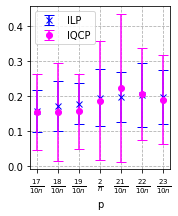

In [19]:
# gurobi, N=100
# p=1 , f=1
import matplotlib.pyplot as plt
import numpy as np

lb = 7  # min 0 0-7, 14-21
ub = 14 # max 21

# ILP
runtime1 = [0.041726933333340335, 0.05064977333335416, 0.06430641666667422, 0.08177841666669489, 0.10570811000005355, 0.11477205666666729, 0.13499182666668427, 0.15758193333332807, 0.17164110000001073, 0.17781149999999948, 0.1948270333333312, 0.19692810666664778, 0.20299044000000777, 0.19605042000001352, 0.21662717666666442, 0.23442169666664087, 0.2865346400000059, 0.26782072666667317, 0.35687835666666007, 0.3652842266666994, 0.43523903000000247]
stdev_runtime1 = [0.016675361049141843, 0.019892231112322394, 0.03407616934985892, 0.04530034012516182, 0.047828673976099835, 0.04746382184049671, 0.048055925710535914, 0.05960916032292353, 0.07048091372707724, 0.05780151504490196, 0.08103923760502044, 0.07122855853731289, 0.09248835575657918, 0.07666772580365341, 0.13426199243327228, 0.1950437446966497, 0.22998996800409216, 0.20390319874883606, 0.3555310633197324, 0.34001197389722493, 0.3934502243645597]

# IQCP
runtime2 = [0.040662709999962014, 0.04378826333334018, 0.06169806666666773, 0.07239220666668492, 0.09268114333333415, 0.10576383000002351, 0.11482967333330786, 0.154485413333335, 0.1536911099999846, 0.15565685000001395, 0.18689241333332424, 0.22286489666667725, 0.20487729999998314, 0.18903398000000682, 0.25048427000000023, 0.23078795333334862, 0.2918405099999973, 0.2759064666666745, 0.41908957333335667, 0.4011792066666582, 0.6790396733333334]
stdev_runtime2 = [0.020904928610134606, 0.022614912423565534, 0.031003035728950894, 0.03966537106247409, 0.04281962542880798, 0.04438895745048114, 0.039631584757319045, 0.1082902753201241, 0.14065257844773582, 0.10759784869753282, 0.1711554961630797, 0.2118215416110336, 0.13208373522481767, 0.12720220701202736, 0.2247943347993973, 0.23338614228793492, 0.3217660710817479, 0.2915125235190083, 0.5745233872775745, 0.5462930285111076, 1.644769734665767]

runtime1 = runtime1[lb:ub]
stdev_runtime1 = stdev_runtime1[lb:ub]

runtime2 = runtime2[lb:ub]
stdev_runtime2 = stdev_runtime2[lb:ub]

x_labels = [r'$\frac{1}{n}$',r'$\frac{11}{10n}$',r'$\frac{12}{10n}$',r'$\frac{13}{10n}$',r'$\frac{14}{10n}$',r'$\frac{15}{10n}$',r'$\frac{16}{10n}$',r'$\frac{17}{10n}$',r'$\frac{18}{10n}$',r'$\frac{19}{10n}$',r'$\frac{2}{n}$',r'$\frac{21}{10n}$',r'$\frac{22}{10n}$',r'$\frac{23}{10n}$',r'$\frac{24}{10n}$',r'$\frac{25}{10n}$',r'$\frac{26}{10n}$',r'$\frac{27}{10n}$',r'$\frac{28}{10n}$',r'$\frac{29}{10n}$',r'$\frac{3}{n}$']
x_labels = x_labels[lb:ub]

x_positions = np.arange(len(runtime1)) # Create x positions for each valu

plt.errorbar(x_positions, runtime1, yerr=stdev_runtime1, fmt='x', capsize=5, color='blue', label='ILP')
#plt.xticks(x_positions, [r"Value {i+1}" for i in []],rotation=45) # Add labels to the x-axis

plt.errorbar(x_positions, runtime2, yerr=stdev_runtime2, fmt='o', capsize=5, color='magenta', label='IQCP')
plt.xticks(x_positions, x_labels) # Add labels to the x-axis
plt.xlabel("p")
#plt.ylabel("seconds")
plt.legend()
# Sets width to 8 inches and height to 6 inches
#plt.title("Values with Standard Deviation")
plt.grid(True, axis='both', linestyle='--') # Add a grid for better readability
fig = plt.gcf()
fig.set_size_inches(2.5, 3)

plt.savefig('gurobi_7_14_100_1_1.pdf')
plt.show()

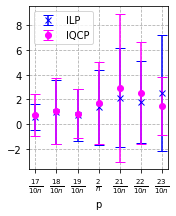

In [23]:
# scip, N=100
# p=1 , f=1
import matplotlib.pyplot as plt
import numpy as np

lb = 7  # min 0
ub = 14 # max 21

# ILP
runtime1 = [0.08068274999999024, 0.08875868333332922, 0.12444031999992451, 0.17057136666667247, 0.24466485666663781, 0.27405073666661034, 0.303186206666669, 0.5849949933333392, 1.0018040333333527, 0.7461833133332675, 1.3559965133333511, 2.144952516666702, 1.7941092333333322, 2.5143704100000224, 2.413746730000048, 3.266906563333214, 3.972040733333294, 3.080163733333393, 5.81121779999994, 5.734036219999992, 6.259764283333273]
stdev_runtime1 = [0.048126753683131435, 0.044758483895006855, 0.08480694634266665, 0.13148066854304843, 0.15371521289050533, 0.14945818386330167, 0.12841195052121526, 1.0831028024237448, 2.591549156008575, 2.1120332160800155, 3.0282842970242045, 3.983761141133931, 3.351115542991344, 4.689933233036709, 4.168564521895932, 5.467780036674302, 5.747665829648365, 4.513407434107187, 7.0890400774360405, 6.05365361630933, 6.836950042720904]

# IQCP
runtime2 = [0.07643837333334887, 0.09501429333346702, 0.11378774333334149, 0.14189058999994206, 0.193403580000025, 0.24341939333338208, 0.3269237699999697, 0.7319648933333762, 1.0770633900000575, 0.844425569999991, 1.7180614533334544, 2.9340590133333535, 2.5056285366667606, 1.4855016866667028, 3.660707786666656, 2.38257815333327, 4.064667596666701, 2.6052363600000112, 8.311369096666748, 6.911196239999996, 17.165323356666704]
stdev_runtime2 = [0.03898783343062194, 0.04643133320781179, 0.10070862397577021, 0.12178364643715656, 0.15662467444649938, 0.2151375374132921, 0.5197520958824609, 1.7302121628170353, 2.662860801481002, 1.9795885757858622, 3.332863520394411, 6.004034910121471, 4.132413431053553, 2.374091497127799, 8.504456162677162, 4.780317003242109, 7.012802362592901, 4.1068774861580835, 18.652513650495212, 17.9767822098059, 62.25250803775873]

runtime1 = runtime1[lb:ub]
stdev_runtime1 = stdev_runtime1[lb:ub]

runtime2 = runtime2[lb:ub]
stdev_runtime2 = stdev_runtime2[lb:ub]

x_labels = [r'$\frac{1}{n}$',r'$\frac{11}{10n}$',r'$\frac{12}{10n}$',r'$\frac{13}{10n}$',r'$\frac{14}{10n}$',r'$\frac{15}{10n}$',r'$\frac{16}{10n}$',r'$\frac{17}{10n}$',r'$\frac{18}{10n}$',r'$\frac{19}{10n}$',r'$\frac{2}{n}$',r'$\frac{21}{10n}$',r'$\frac{22}{10n}$',r'$\frac{23}{10n}$',r'$\frac{24}{10n}$',r'$\frac{25}{10n}$',r'$\frac{26}{10n}$',r'$\frac{27}{10n}$',r'$\frac{28}{10n}$',r'$\frac{29}{10n}$',r'$\frac{3}{n}$']
x_labels = x_labels[lb:ub]

x_positions = np.arange(len(runtime1)) # Create x positions for each valu

plt.errorbar(x_positions, runtime1, yerr=stdev_runtime1, fmt='x', capsize=5, color='blue', label='ILP')
#plt.xticks(x_positions, [f"Value {i+1}" for i in []],rotation=45) # Add labels to the x-axis

plt.errorbar(x_positions, runtime2, yerr=stdev_runtime2, fmt='o', capsize=5, color='magenta', label='IQCP')
plt.xticks(x_positions, x_labels) # Add labels to the x-axis
plt.xlabel("p")
#plt.ylabel("seconds")
plt.legend()
#plt.title("Values with Standard Deviation")
plt.grid(True, axis='both', linestyle='--') # Add a grid for better readability

fig = plt.gcf()
fig.set_size_inches(2.5, 3)

plt.savefig('scip_7_14_100_1_1.pdf')
plt.show()

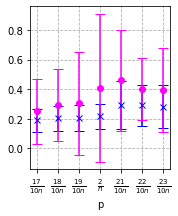

In [27]:
# gurobi, N=100
# p=1 , f=2
import matplotlib.pyplot as plt
import numpy as np

lb = 7  # min 0
ub = 14 # max 21

# ILP
runtime1 = [0.042167416666749585, 0.05467426000001675, 0.07255949333333168, 0.09980196666674601, 0.11752428666671524, 0.14236202666667547, 0.17111695666665885, 0.18845296666680345, 0.2030982399999933, 0.20370911000009073, 0.2178433233333029, 0.2913514866667659, 0.29019774333334375, 0.281952383333252, 0.37130776333333415, 0.36261106999997234, 0.47330036666677794, 0.5023412099999708, 0.6445085266666866, 0.6297460066666948, 0.6724337133333695]
stdev_runtime1 = [0.0206851985421016, 0.02743148369711141, 0.04545413009483233, 0.07047760699548868, 0.06093359209249578, 0.06412160804262142, 0.07002442680862031, 0.07539859352502731, 0.08337309150717072, 0.08941441573575143, 0.08385135294597507, 0.16367601037529683, 0.13693055990259176, 0.14456692632249646, 0.2560767706819958, 0.27713640858619853, 0.25144802307572356, 0.2706246336950713, 0.33573013181792455, 0.2998575908963692, 0.41452856837719965]

# IQCP
runtime2 = [0.03952494999994087, 0.04987751333331592, 0.06548420666670912, 0.08484232666666382, 0.1567325700000462, 0.15218575333334836, 0.19783463000018553, 0.24953288000003038, 0.29454229666680476, 0.3063260633333205, 0.4086195566666902, 0.4591845633332317, 0.40176045999996857, 0.3953563900000821, 0.6550500733332835, 0.4715837966666792, 0.6492581833334347, 0.6890050599999389, 1.0330527200000688, 1.0797855099999651, 1.053717643333251]
stdev_runtime2 = [0.015842210286154196, 0.023022402545077404, 0.039481581287371934, 0.05425934267948715, 0.21011472174875764, 0.09513446419387697, 0.11235135647764852, 0.21959482339831848, 0.2454588489827045, 0.34865047816133515, 0.5016733037636961, 0.3399703718058285, 0.21187486334214678, 0.2850280932479695, 0.8300632378914123, 0.45541343017150837, 0.49481239373790387, 0.5104318049781776, 0.9163679316388609, 1.320675437938539, 1.395199336626937]

runtime1 = runtime1[lb:ub]
stdev_runtime1 = stdev_runtime1[lb:ub]

runtime2 = runtime2[lb:ub]
stdev_runtime2 = stdev_runtime2[lb:ub]

x_labels = [r'$\frac{1}{n}$',r'$\frac{11}{10n}$',r'$\frac{12}{10n}$',r'$\frac{13}{10n}$',r'$\frac{14}{10n}$',r'$\frac{15}{10n}$',r'$\frac{16}{10n}$',r'$\frac{17}{10n}$',r'$\frac{18}{10n}$',r'$\frac{19}{10n}$',r'$\frac{2}{n}$',r'$\frac{21}{10n}$',r'$\frac{22}{10n}$',r'$\frac{23}{10n}$',r'$\frac{24}{10n}$',r'$\frac{25}{10n}$',r'$\frac{26}{10n}$',r'$\frac{27}{10n}$',r'$\frac{28}{10n}$',r'$\frac{29}{10n}$',r'$\frac{3}{n}$']
x_labels = x_labels[lb:ub]

x_positions = np.arange(len(runtime1)) # Create x positions for each valu

plt.errorbar(x_positions, runtime1, yerr=stdev_runtime1, fmt='x', capsize=5, color='blue', label='ILP')
#plt.xticks(x_positions, [r"Value {i+1}" for i in []],rotation=45) # Add labels to the x-axis

plt.errorbar(x_positions, runtime2, yerr=stdev_runtime2, fmt='o', capsize=5, color='magenta', label='IQCP')
plt.xticks(x_positions, x_labels) # Add labels to the x-axis
plt.xlabel("p")
#plt.ylabel("seconds")
#plt.legend()
#plt.title("Values with Standard Deviation")
plt.grid(True, axis='both', linestyle='--') # Add a grid for better readability

fig = plt.gcf()
fig.set_size_inches(2.5, 3)

plt.savefig('gurobi_7_14_100_2_1.pdf')
plt.show()

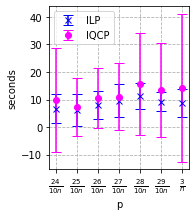

In [30]:
# scip, N=100
# p=1 , f=2
import matplotlib.pyplot as plt
import numpy as np

lb = 14  # min 0
ub = 21 # max 21

# ILP
runtime1 = [0.09510509000001548, 0.08668636999994608, 0.13333696333338593, 0.18863909333334353, 0.27500628333345956, 0.45665896333339334, 0.6796452900000683, 1.3760990866665754, 1.3569003966667272, 1.2484936766665669, 3.128355316666542, 3.1764106333333983, 4.3416282099997865, 4.73246396333343, 6.621768749999926, 6.320527406666709, 8.033494573333519, 9.636486973333376, 11.179868400000183, 9.186649573333488, 8.801252776666722]
stdev_runtime1 = [0.05721144169889562, 0.03760658912319933, 0.09850364898601321, 0.15669907266277863, 0.19685061184786865, 0.7449914726797681, 0.9712674335808131, 2.363435702940984, 2.8137631788754205, 2.061335967932833, 4.615644507012367, 4.113495241335212, 4.7271738273848065, 4.828796125261498, 5.262940190252844, 5.804327927798439, 5.084405041622071, 5.9458950309299965, 4.761530320584658, 3.4484262561071266, 4.954080918913537]

# IQCP
runtime2 = [0.08123713666676242, 0.11721893666684385, 0.24580427333318464, 0.36499076666677865, 1.1836231766666363, 1.2209847833333698, 1.9572017833333424, 3.5798609933333863, 3.7779406799999076, 4.047027946666883, 4.265861986666581, 6.11339065000005, 5.908403539999744, 4.943872270000066, 9.712190306666587, 7.270151746666548, 10.559918893333391, 11.106229640000189, 15.728892996666643, 13.343576833333161, 14.220369263333305]
stdev_runtime2 = [0.04483368758564156, 0.08692371553967268, 0.4150900259374874, 0.623753799425334, 2.819984858902674, 2.0366275048679507, 2.397403535821602, 4.629502035866566, 4.783285962994848, 6.339987080095346, 6.3027495276266405, 5.679503956760573, 4.933849490423444, 4.7585304297937885, 18.919339058391447, 10.422812871581979, 10.908809838662158, 12.288872709958753, 18.4455681286032, 17.08084935517538, 26.9157197832201]

runtime1 = runtime1[lb:ub]
stdev_runtime1 = stdev_runtime1[lb:ub]

runtime2 = runtime2[lb:ub]
stdev_runtime2 = stdev_runtime2[lb:ub]

x_labels = [r'$\frac{1}{n}$',r'$\frac{11}{10n}$',r'$\frac{12}{10n}$',r'$\frac{13}{10n}$',r'$\frac{14}{10n}$',r'$\frac{15}{10n}$',r'$\frac{16}{10n}$',r'$\frac{17}{10n}$',r'$\frac{18}{10n}$',r'$\frac{19}{10n}$',r'$\frac{2}{n}$',r'$\frac{21}{10n}$',r'$\frac{22}{10n}$',r'$\frac{23}{10n}$',r'$\frac{24}{10n}$',r'$\frac{25}{10n}$',r'$\frac{26}{10n}$',r'$\frac{27}{10n}$',r'$\frac{28}{10n}$',r'$\frac{29}{10n}$',r'$\frac{3}{n}$']
x_labels = x_labels[lb:ub]

x_positions = np.arange(len(runtime1)) # Create x positions for each valu

plt.errorbar(x_positions, runtime1, yerr=stdev_runtime1, fmt='x', capsize=5, color='blue', label='ILP')
#plt.xticks(x_positions, [r"Value {i+1}" for i in []],rotation=45) # Add labels to the x-axis

plt.errorbar(x_positions, runtime2, yerr=stdev_runtime2, fmt='o', capsize=5, color='magenta', label='IQCP')
plt.xticks(x_positions, x_labels) # Add labels to the x-axis
plt.xlabel("p")
plt.ylabel("seconds")
plt.legend()
#plt.title("Values with Standard Deviation")
plt.grid(True, axis='both', linestyle='--') # Add a grid for better readability

fig = plt.gcf()
fig.set_size_inches(2.5, 3)

plt.savefig('scip_14_21_100_2_1.pdf')
plt.show()